**Predictors Affecting the Current Rank of Professional Singles Male Tennis Players**

**Introduction:**
The performance of professional male tennis players is accessed objectively by the Association of Tennis Professionals (ATP) ranking system. Players gain points according to their round of exit and the scale of the tournament. Typically, points are valid for 52 weeks.
This project uses the player_stat dataset to predict the current rank of professional singles male tennis players by age and experience, thus answering the research questions:
How does age affect players’ current rank?
How does experience, as reflected by seasons played, affect players’ current rank? 
The player_stat dataset contains information on singles male tennis players ranked in the top 500 in the ATP scoring system from 2020. The columns are defined below:
Age;
Current rank: refers to ATP rank;
Seasons played: a season is defined as a calendar year in professional tennis.

**Preliminary exploratory data analysis:**

In [11]:
#Load libraries here
library(tidyverse)
library(tidymodels)
library(gridExtra)
library(repr)

In [12]:
#Read data
tennis_data_raw <- read_csv("https://drive.google.com/uc?export=download&id=1_MECmUXZuuILYeEOfonSGqodW6qVdhsS")
#tennis_data_raw

Warning message:
“Missing column names filled in: 'X1' [1]”
Parsed with column specification:
cols(
  .default = col_character(),
  X1 = col_double(),
  `Turned Pro` = col_double(),
  Seasons = col_double(),
  Titles = col_double(),
  `Best Season` = col_double(),
  Retired = col_double(),
  Masters = col_double(),
  `Grand Slams` = col_double(),
  `Davis Cups` = col_double(),
  `Team Cups` = col_double(),
  Olympics = col_double(),
  `Weeks at No. 1` = col_double(),
  `Tour Finals` = col_double()
)

See spec(...) for full column specifications.



In [13]:
#Tidying data
names(tennis_data_raw) <- make.names(names(tennis_data_raw), unique = TRUE)
tennis_data_tidy <- tennis_data_raw %>% 
mutate(Last_Appearance = Last.Appearance) %>%
select(-Wikipedia, -X1) %>%
#Separating values
separate(col = Age, into = c("Age", "Birthdate"), sep = " ") %>%
separate(col = Current.Rank, into = c("Current_Rank", "Points_at_Current_Rank"), sep = " ") %>% 
separate(col = Best.Rank, into = c("Best_Rank", "Best_Rank_Date"), sep = " ") %>%
separate(col = Current.Elo.Rank, into = c("Current_Elo_Rank", "Current_Elo_Score"), sep = " ") %>% 
separate(col = Best.Elo.Rank, into = c("Best_Elo_Rank", "Best_Elo_Rank_Date"), sep = " ") %>% 
separate(col = Peak.Elo.Rating, into = c("Peak_Elo_Rating", "Peak_Elo_Rating_Date"), sep = " ") %>% 
separate(col = GOAT.Rank, into = c("GOAT_Rank", "GOAT_Points"), sep = " ") %>%
lapply( function(x) gsub(pattern = "[\\(\\)]",replacement = "", as.character(x))) %>%
data.frame() %>%
#Converting Date format
separate(col = Birthdate, into = c("Birthday","Birthmonth", "Birthyear"), sep = "-") %>% 
separate(col = Best_Rank_Date, into = c("Best_Rank_Day", "Best_Rank_Month", "Best_Rank_Year"), sep = "-") %>%
separate(col = Peak_Elo_Rating_Date, into = c("Peak_Elo_Rating_Day", "Peak_Elo_Rating_Month" ,"Peak_Elo_Rating_Year"), sep = "-") %>%
separate(col = Best_Elo_Rank_Date, into = c("Best_Elo_Rank_Day", "Best_Elo_Rank_Month" ,"Best_Elo_Rank_Year"), sep = "-") %>%
separate(col = Last_Appearance, into = c("Last_Appearance_Day", "Last_Appearance_Month" ,"Last_Appearance_Year"), sep = "-") %>%
#Converting to int
mutate_at(c("Age", "Birthday", "Birthmonth", "Birthyear", "Current_Rank", "Points_at_Current_Rank", "Current_Elo_Rank", "Best_Rank", "Best_Rank_Day", "Current_Elo_Score",
            "Best_Rank_Year", "Peak_Elo_Rating_Day", "Peak_Elo_Rating_Month", "Peak_Elo_Rating_Year", "Peak_Elo_Rating", "Best.Season", "Retired",
            "Best_Elo_Rank", "Best_Elo_Rank_Day", "Best_Elo_Rank_Month" ,"Best_Elo_Rank_Year","Last_Appearance_Day", "Last_Appearance_Month" ,"Last_Appearance_Year", 
            "GOAT_Rank", "GOAT_Points", "Grand.Slams", "Davis.Cups", "Olympics", "Team.Cups", "Turned.Pro", "Seasons", "Titles" ), as.integer) %>%
mutate( Age_at_Best_Rank = Best_Rank_Year - Birthyear)
       
tennis_data_tidy$Retired[tennis_data_tidy$Retired > 1990] <- "yes"
tennis_data_tidy$Retired[is.na(tennis_data_tidy$Retired)] <- "no"
       
#Removed many vectors for easier viewing of table
tennis_data_filtered <- tennis_data_tidy %>%
                   #Likely irrelevant vectors
                   select(-Facebook, - Twitter, - Nicknames, -Coach, -Web.Site, -Residence, -Birthplace) %>%      
                   #Possibly irrelevant vectors 
                   select(-Davis.Cups, -Team.Cups, -Olympics, - Weight, -Grand.Slams, -Tour.Finals,-Masters, -Weeks.at.No..1, 
                           -Height, -Prize.Money, -Last.Appearance, -Titles, -Active) %>%       
                   #Days and Months
                   select(-Birthday, -Birthmonth, -Best_Rank_Day, -Best_Rank_Month, -Peak_Elo_Rating_Day, -Peak_Elo_Rating_Month,
                          -Best_Elo_Rank_Day, -Best_Elo_Rank_Month, - Last_Appearance_Day, -Last_Appearance_Month) %>% 
                   arrange(Current_Rank)
           
#tennis_data_tidy
tennis_data_filtered     

Age,Birthyear,Country,Plays,Current_Rank,Points_at_Current_Rank,Best_Rank,Best_Rank_Year,Name,Backhand,⋯,Best_Elo_Rank,Best_Elo_Rank_Year,Peak_Elo_Rating,Peak_Elo_Rating_Year,GOAT_Rank,GOAT_Points,Best.Season,Retired,Last_Appearance_Year,Age_at_Best_Rank
<int>,<int>,<chr>,<chr>,<int>,<int>,<int>,<int>,<chr>,<chr>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<chr>,<int>,<int>
33,1986,Spain,Left-handed,1,10235,1,2008,Rafael Nadal,Two-handed,⋯,1,2008,2552,2013,3,805,2010,no,2019,22
32,1987,Serbia,Right-handed,2,9720,1,2011,Novak Djokovic,Two-handed,⋯,1,2011,2629,2016,2,819,2015,no,2019,24
38,1981,Switzerland,Right-handed,3,6590,1,2004,Roger Federer,One-handed,⋯,1,2003,2550,2007,1,929,2006,no,2019,23
23,1996,Russian Federation,Right-handed,4,5960,4,2019,Daniil Medvedev,Two-handed,⋯,4,2019,2243,2019,109,27,2019,no,2019,23
26,1993,Austria,Right-handed,5,5890,4,2017,Dominic Thiem,One-handed,⋯,5,2019,2211,2019,58,58,2019,no,2019,24
21,1998,Greece,Right-handed,6,5375,5,2019,Stefanos Tsitsipas,One-handed,⋯,8,2019,2175,2019,139,21,2019,no,2019,21
22,1997,Germany,Right-handed,7,3345,3,2017,Alexander Zverev,Two-handed,⋯,5,2017,2231,2017,65,54,2018,no,2019,20
23,1996,Italy,Right-handed,8,2870,8,2019,Matteo Berrettini,Two-handed,⋯,13,2019,2102,2019,245,7,2019,no,2019,23
31,1988,Spain,Right-handed,9,2630,9,2019,Roberto Bautista Agut,Two-handed,⋯,9,2019,2135,2016,151,18,2019,no,2019,31


In [14]:
#Table with relevant predictors
tennis_data_by_country <- tennis_data_filtered %>%
                       group_by(Country) %>%
                       summarize(Players_per_Country = n(), Mean_Age = mean(Age, na.rm=TRUE), Mean_Current_Rank = mean(Current_Rank, na.rm = TRUE),
                                 Best_Current_Rank = min(Current_Rank, na.rm = TRUE)) %>%
                       arrange(desc(Players_per_Country))
tennis_data_by_country

Warning message in min(Current_Rank, na.rm = TRUE):
“no non-missing arguments to min; returning Inf”
`summarise()` ungrouping output (override with `.groups` argument)



Country,Players_per_Country,Mean_Age,Mean_Current_Rank,Best_Current_Rank
<chr>,<int>,<dbl>,<dbl>,<dbl>
France,46,25.39130,252.5435,10
United States,41,25.14634,235.5641,19
Italy,37,26.05405,249.2432,8
Spain,34,27.29412,240.3235,1
Germany,30,27.33333,245.7931,7
Argentina,28,25.25000,255.9286,14
Australia,23,25.17391,213.6087,23
Russian Federation,20,24.90000,289.9500,4
Japan,19,25.47368,259.6842,18


Warning message:
“Removed 126 rows containing missing values (geom_point).”


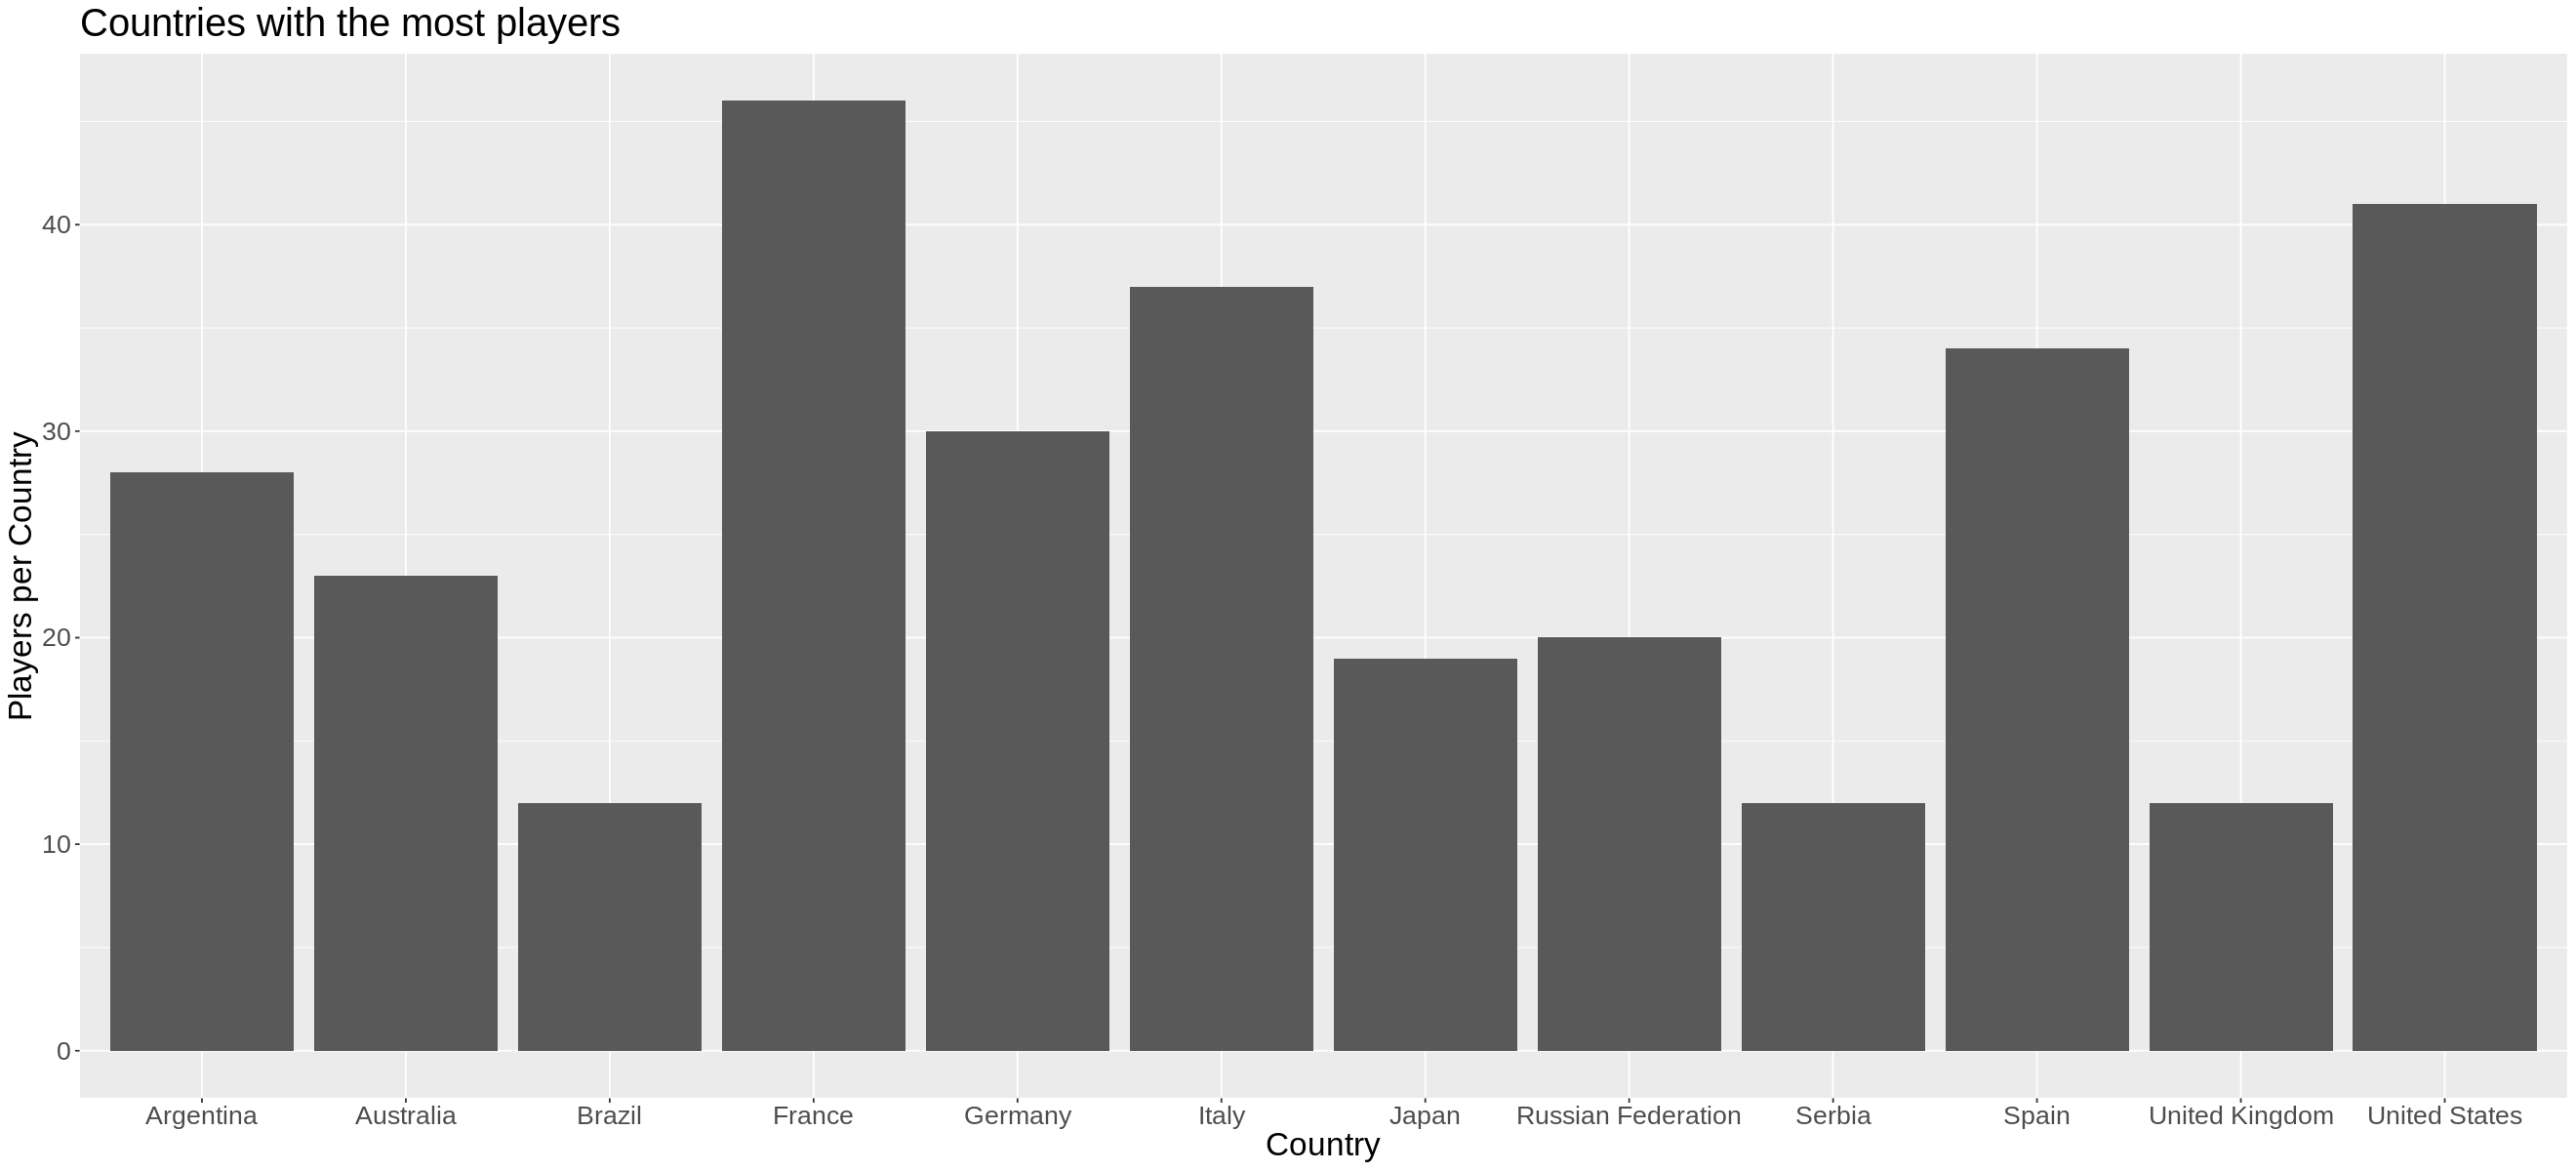

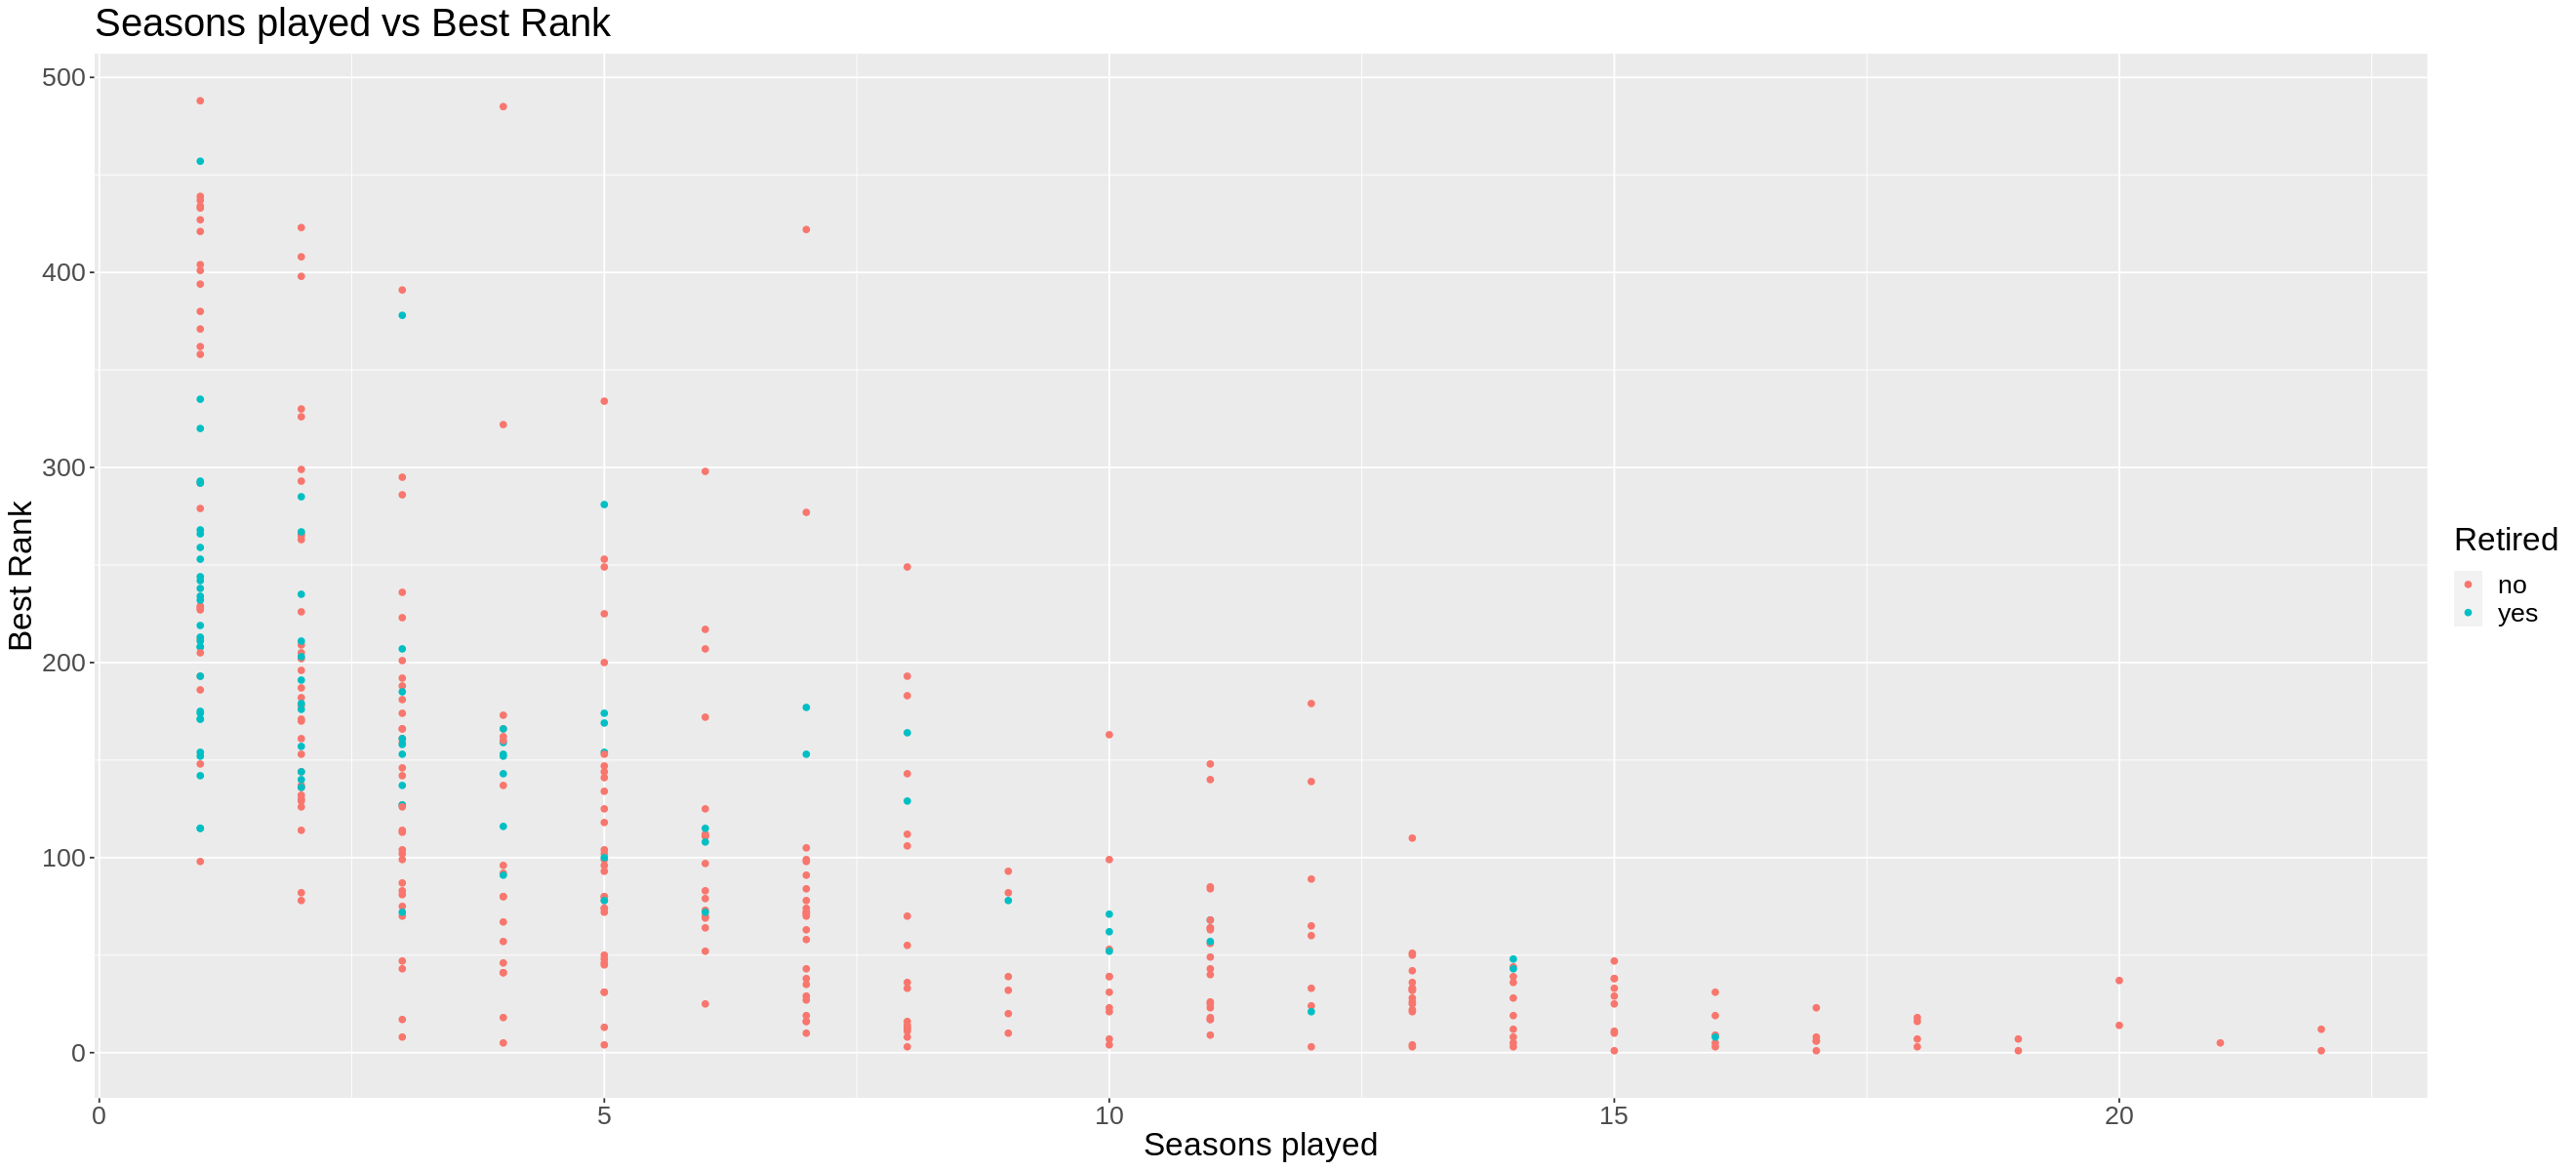

In [15]:
#Relevant Plots
options(repr.plot.width = 22, repr.plot.height = 10)
player_per_country_distribution <-  tennis_data_by_country %>%
                                    head(12) %>%
                                    ggplot( aes(x= Country, y= Players_per_Country)) +
                                    geom_bar(stat= "identity", position = "dodge") +
                                    labs(x = "Country", y = "Players per Country") +
                                    theme(text = element_text(size =20)) +
                                    ggtitle("Countries with the most players")
player_per_country_distribution 
age_vs_best_rank <- tennis_data_filtered %>%
                    ggplot(aes(color = Retired, x = Seasons, y= Best_Rank)) +
                    geom_point() +
                    labs(x = "Seasons played", y = "Best Rank") +
                    theme(text = element_text(size =20)) +
                    ggtitle("Seasons played vs Best Rank")
age_vs_best_rank

**Methods**

-Set the seed for our data so our methods are reproducible;

-Split the dataset into a training and test set.

-Use cross-validation to calculate the best K for the most accurate results, using the root mean square error (RMSPE):
 
-Create a recipe to scale and center our predictor variables using recipe(), step_scale(), and step_center() using only our training set.

-Create the model using nearest_neighbor(), set_engine(), set_mode(), and setting the neighbors argument to tune().

-Use the vfold_cv() and stratify by current_rank to create cross-validation object. 

-Make workflow using recipe and model. Observe how the number of neighbors affects RMSPE.

-Create a grid of numbers 1:300 using tibble() and collect_metrics(), to see what RMSPE value is given for each K value used in the model. To find the best K value for our model (producing the lowest RMSPE), filter  results to find minimum RMSPE value and the corresponding K value.

-Evaluate the model: re-training it using the training set and K value obtained from the previous step. 

-Use predict() to predict current rank values for the test set data. Use bind_cols() to add a column of predictions to the test set for comparison with true values.

-Summarize accuracy of known test set current rank values to the predicted current rank values using metrics(). 

-Use model to make predictions about current rank for new observations.

**Expected outcomes and significance**

This project expects to determine how age and experience (reflected by seasons played) affect a players’ current rank. The hypothesis is that players would obtain higher ranks as they age and gain more experience (have more seasons played). Circumstances such as illness and injury that might halt players’ careers are not taken into account in this project. 
It was commonly believed that players’ physical strength would deteriorate over years. However, some current players such as Novak Djokovic, Rafael Nadal, and Roger Federer are able to win major tournaments such as Grand Slams after they reach 30, a relatively senior age for professional tennis players. This project would give a vision of to what extent current players lengthen their peak and careers, perhaps due to improving training methods and medical technology. 
The project could lead to future questions such as:

Do age and experience play a similar role in determining the current rank of players in other types of tennis games such as Men’s doubles, Women’s singles, and Mixed doubles.

Quantitatively determine to what extent age and seasons played each contribute into a players’ current rank, and whether they share a similar weight in determining the players’ current rank.

Are other racket sports such as badminton and squash also affected the same way as tennis when it comes to factors such as age and experience, or are they affected differently?
